# Imports

In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Utilities

In [2]:
# Helper function to plot fake images
# Used to visualize outputs from GAN while it is being trained
def plot_multiple_images(images,n_cols = None):
  # Visualization fake images
  display.clear_output(wait = False)
  # If n_cols is not provided, it is set to the number of images.
  n_cols = n_cols or len(images)
  n_rows = (len(images) - 1) // n_cols + 1

  # If the images have a single channel (e.g., grayscale images with shape
  # [height, width, 1]), they are squeezed to remove the last dimension,
  # resulting in shape [height, width].
  if images.shape[-1] == 1:
    images = np.squeeze(images,axis = -1)

  plt.figure(figsize = (n_cols,n_rows))

  for index, image in enumerate(images):
    plt.subplot(n_rows,n_cols,index + 1)
    # Displays the image in the subplot using a binary colormap (black and white).
    plt.imshow(image,cmap = 'binary')
    plt.axis('off')

# Download and Prepare the Dataset

In [3]:
# load the train set of the MNIST dataset
(X_train, _), _ = tf.keras.datasets.mnist.load_data()

# normalize pixel values
X_train = X_train.astype(np.float32) / 255

11490434/11490434 [==============================] - 2s 0us/step


In [4]:
BATCH_SIZE = 128

dataset = tf.data.Dataset.from_tensor_slices(X_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE,drop_remainder = True).prefetch(1)

## Build the Model

### Generator

In [5]:
# Generator - Creates the fake data
# Discriminator - Determines if an image if fake or real

# The generator takes in random noise and uses it to create fake images.
# For that, this model will take in the shape of the random noise and
# will output an image with the same dimensions of the MNIST dataset
# (i.e. 28 x 28).

# Declare shape of the noise input
random_normal_dimensions = 32

generator = tf.keras.models.Sequential([
    tf.keras.layers.Dense(64,activation = 'selu',input_shape = [random_normal_dimensions]),
    tf.keras.layers.Dense(128,activation = 'selu'),
    tf.keras.layers.Dense(28*28,activation = 'sigmoid'),
    tf.keras.layers.Reshape([28,28])
])

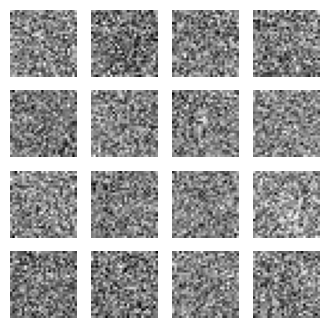

In [6]:
# Testing

# Generate a batch of noise input (batch_size = 16)
test_noise = tf.random.normal([16,random_normal_dimensions])

# Feed the batch to the untrained generator
test_image = generator(test_noise)

# Visualize sample output
plot_multiple_images(test_image,n_cols = 4)

### Discriminator

In [7]:
# The discriminator takes in the input (fake or real) images and determines
# if it is fake or not. Thus, the input shape will be that of the training images.
# This will be flattened so it can be fed to the dense networks and the final output
# is a value between 0 (fake) and 1 (real).

# Build the discriminator model
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape = [28,28]),
    tf.keras.layers.Dense(128,activation = 'selu'),
    tf.keras.layers.Dense(64,activation = 'selu'),
    tf.keras.layers.Dense(1,activation = 'sigmoid')
])

In [8]:
gan = tf.keras.models.Sequential([
    generator,
    discriminator
])

# Configure Training Parameters

In [9]:
discriminator.compile(loss = 'binary_crossentropy',
                      optimizer = 'rmsprop')
discriminator.trainable = False
gan.compile(loss = 'binary_crossentropy',
            optimizer = 'rmsprop')

# Train the Model

Model training consists of two phases:

* Phase 1 - trains the discriminator to distinguish between fake or real data
* Phase 2 - trains the generator to generate images that will trick the discriminator

In [14]:
def train_gan(gan,dataset,random_normal_dimensions,n_epochs = 50):
  # Get the two sub networks from the GAN model
  generator,discriminator = gan.layers

  # Start loop
  for epoch in range(n_epochs):
    print("Epoch {}/{}".format(epoch + 1,n_epochs))
    for real_images in dataset:
      # Infer batch size from the training batch
      batch_size = real_images.shape[0]

      # Train the discriminator - PHASE 1
      # Create the noise
      noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])

      # Use the noise to generate fake images
      fake_images = generator(noise)

      # Create a list by concatenating the fake images with the real ones
      mixed_images = tf.concat([fake_images,real_images],axis = 0)

      # Create the labels for the discriminator
      # 0 - for the fake images
      # 1 - for the real images
      discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)

      # Ensure the discriminator is trainable
      discriminator.trainable = True

      # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
      discriminator.train_on_batch(mixed_images,discriminator_labels)

      # Train the generator - PHASE 2
      # Create a batch of noise input to feed to the GAN
      noise = tf.random.normal(shape = [batch_size,random_normal_dimensions])

      # Label all generated images to be "real"
      # By setting the labels of the generated images to 1 (real), you essentially tell the GAN model
      # that you want the generator to produce images that the discriminator classifies as real. The
      # loss function will then adjust the generator's weights to minimize the difference between the
      # predicted labels and the target labels (which are set to 1). This encourages the generator to
      # create more realistic images over time.
      generator_labels = tf.constant([[1.]] * batch_size)

      # Freeze the discriminator
      discriminator.trainable = False

      # Train the GAN on the noise with the labels all set to be true
      gan.train_on_batch(noise,generator_labels)

    # Plot the fake images used to train the generator
    plot_multiple_images(fake_images,8)
    plt.show()

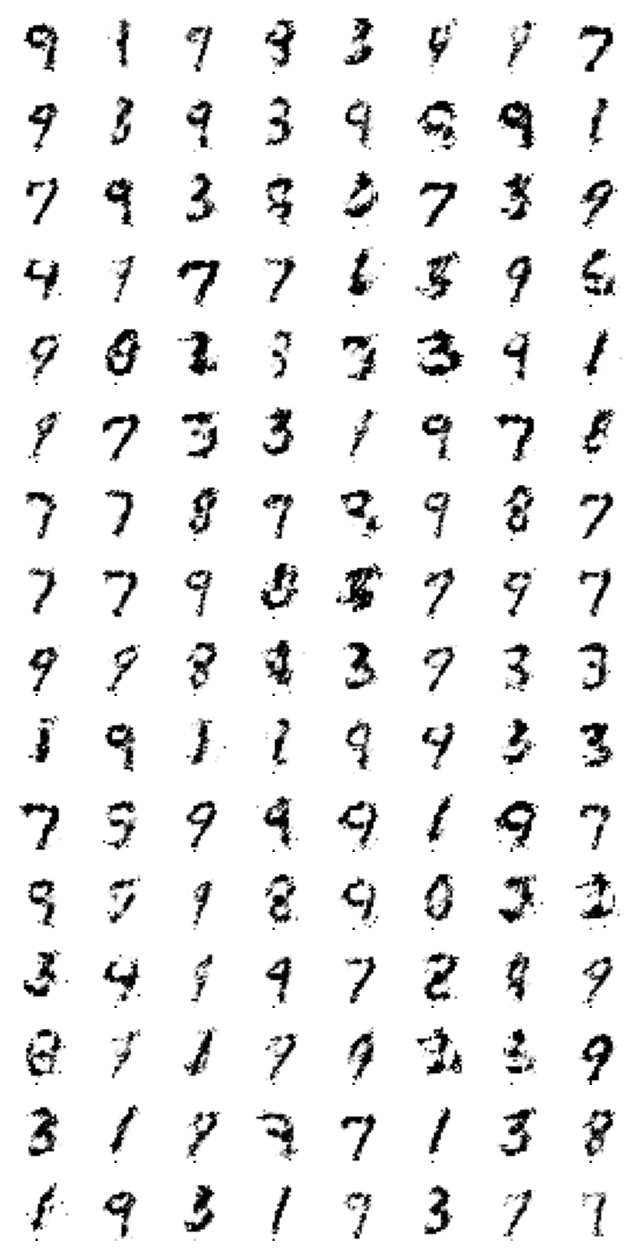

In [15]:
train_gan(gan,dataset,random_normal_dimensions,n_epochs = 20)